In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 

In [3]:
import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USER']
dj.config['database.password'] = os.environ['DJ_PASS']
dj.config['enable_python_native_blobs'] = True
dj.config['display.limit'] = 200

name = 'iclr'
dj.config['schema_name'] = f"konstantin_nnsysident_{name}"

In [4]:
import re
import torch
import numpy as np
import pickle 
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10)
from collections import OrderedDict, Iterable
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import nnfabrik
from nnfabrik.main import *
from nnfabrik import builder
from nnfabrik.utility.hypersearch import Bayesian

from nnsysident.tables.experiments import *
from nnsysident.tables.bayesian import *
from nnsysident.datasets.mouse_loaders import static_shared_loaders, static_loaders, static_loader
from nnsysident.tables.scoring import OracleScore, OracleScoreTransfer

from dataport.bcm.static import PreprocessedMouseData

<ipython-input-4-011c4973676c>:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import OrderedDict, Iterable


Connecting konstantin@134.2.168.16:3306
Schema name: konstantin_nnsysident_iclr


---

In [7]:
Dataset().fetch(limit=1)[0]

('nnsysident.datasets.mouse_loaders.static_loaders', '038f2669af54867d5bce92a0353df93a', {'paths': ['data/static20457-5-9-preproc0.zip'], 'batch_size': 64, 'neuron_n': 5335, 'neuron_base_seed': 1, 'image_n': 2500, 'image_base_seed': 5}, 'kklurz', 'neuron_n=5335, image_n=2500', datetime.datetime(2020, 9, 1, 15, 46, 24))

In [12]:
dataset_config = {'paths': ['data/static20457-5-9-preproc0.h5'], 'batch_size': 64, 'file_tree':False}
dataloaders = static_loaders(**dataset_config)

data/static20457-5-9-preproc0.h5 does not exist locally. Trying to fetch.


FileNotFoundError: Could not load static20457-5-9-preproc0.h5 from database.

In [ ]:
for images, responses in 

In [16]:
dat = dataloaders['train']['20457-5-9-0'].dataset

In [25]:
from tqdm import tqdm

In [36]:
responses = np.stack([d.responses.cpu().data.numpy() for d in tqdm(dat)])

100%|██████████| 5993/5993 [00:07<00:00, 772.30it/s]


In [37]:
trial_idx = dat.trial_info.trial_idx

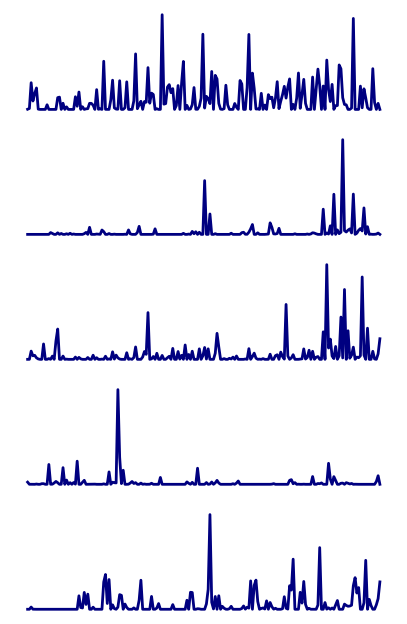

In [63]:
neurons_n = 5
fig, axes = plt.subplots(neurons_n, 1, figsize=(5, 8), dpi=100)
for i in range(neurons_n):
    ax = axes[i]
    ax.plot(sorted_responses.T[i, 100:300], lw=2, c='navy')
    ax.axis('off')
    
fig.savefig("response_traces.png", bbox_inches='tight')

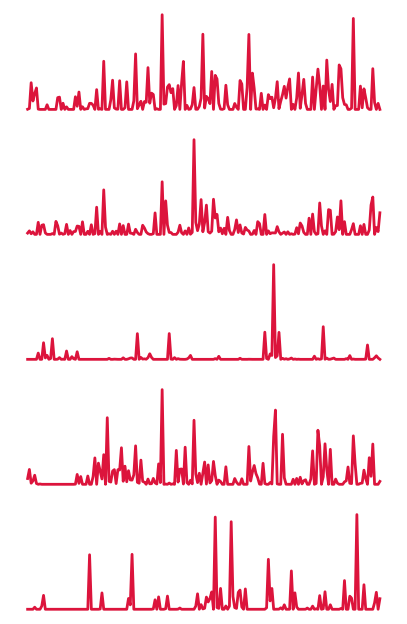

In [62]:
neurons_n = 5
fig, axes = plt.subplots(neurons_n, 1, figsize=(5, 8), dpi=100)
for i in range(neurons_n):
    ax = axes[i]
    ax.plot(sorted_responses.T[-i, 100:300], lw=2, c='crimson')
    ax.axis('off')
    
fig.savefig("response_traces2.png", bbox_inches='tight')

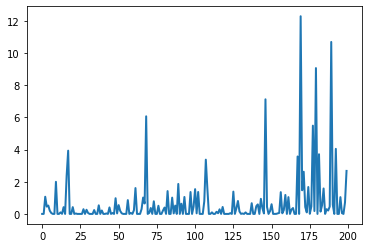

In [46]:
.plot(sorted_responses.T[2, 100:300], lw=2)

# Dataset

In [ ]:
dataset_path, data_key = '/notebooks/data/static20457-5-9-preproc0.h5', "20457-5-9-0"
dataset_config = {'paths': [dataset_path],
                  'batch_size': 64,
                  'areas': 'V1',
                  'normalize': False, 
                  'seed': 4, 
                  'file_tree':False,
                  'neuron_n': None
                 }
dataloaders = static_loaders(**dataset_config)

# Model

In [ ]:
model_fn = 'nnsysident.models.models.se2d_fullgaussian2d'

model_config = dict(data_info=None,
    transfer_state_dict=None,
    # core args
    hidden_channels=64,
    input_kern=9,
    hidden_kern=7,
    layers=4,
    gamma_input=6.3831,
    skip=0,
    bias=False,
    final_nonlinearity=True,
    momentum=0.9,
    pad_input=False,
    batch_norm=True,
    hidden_dilation=1,
    laplace_padding=None,
    input_regularizer="LaplaceL2norm",
    stack=-1,
    se_reduction=32,
    n_se_blocks=0,
    depth_separable=True,
    linear=False,
    # readout args
    init_mu_range=0.3,
    init_sigma=0.1,
    readout_bias=True,
    gamma_readout=0.0076,
    gauss_type="full",
    grid_mean_predictor=None,
    share_features=False,
    share_grid=False,
    share_transform=False,
    init_noise=1e-3,
    init_transform_scale=0.2)


model = builder.get_model(model_fn=model_fn, model_config=model_config, dataloaders=dataloaders, seed=1)

# Trainer

In [ ]:
detach_core=False  # this should be True for transfer learning

trainer_fn = 'nnsysident.training.trainers.standard_trainer'
trainer_config = dict(track_training=True, detach_core=detach_core)  
trainer = builder.get_trainer(trainer_fn, trainer_config)

# Run Training

In [ ]:
score, output, model_state = trainer(model=model, dataloaders=dataloaders, seed=1)

---

In [ ]:
import types
from neuralpredictors.measures import corr
from neuralpredictors.training import eval_state, device_state

def model_predictions(model, dataloader, data_key, device="cpu"):
    """
    computes model predictions for a given dataloader and a model
    Returns:
        target: ground truth, i.e. neuronal firing rates of the neurons
        output: responses as predicted by the network
    """

    target, output = torch.empty(0), torch.empty(0)
    for images, responses in dataloader:
        if len(images.shape) == 5:
            images = images.squeeze(dim=0)
            responses = responses.squeeze(dim=0)
        with torch.no_grad():
            with device_state(model, device) if not isinstance(model, types.FunctionType) else contextlib.nullcontext():
                output = torch.cat((output, (model(images.to(device), data_key=data_key).detach().cpu())), dim=0)
            target = torch.cat((target, responses.detach().cpu()), dim=0)

    return target.numpy(), output.numpy()

def get_correlations(model, dataloaders, device="cpu", as_dict=False, per_neuron=True, **kwargs):
    correlations = {}
    with eval_state(model) if not isinstance(model, types.FunctionType) else contextlib.nullcontext():
        for k, v in dataloaders.items():
            target, output = model_predictions(dataloader=v, model=model, data_key=k, device=device)
            correlations[k] = corr(target, output, axis=0)

            if np.any(np.isnan(correlations[k])):
                warnings.warn("{}% NaNs , NaNs will be set to Zero.".format(np.isnan(correlations[k]).mean() * 100))
            correlations[k][np.isnan(correlations[k])] = 0

    if not as_dict:
        correlations = (
            np.hstack([v for v in correlations.values()])
            if per_neuron
            else np.mean(np.hstack([v for v in correlations.values()]))
        )
    return correlations

In [ ]:
device = 'cuda'
tier = 'test'
corrs = get_correlations(model, dataloaders[tier], device=device, as_dict=False, per_neuron=False)

In [ ]:
corrs

In [ ]:
def get_n_params(model):
    return sum([param.nelement() for param in model.parameters()])

get_n_params(model)